The purpose of this notebook is to explore convolutions and see their role in the segmentation that we worked on in the segmentation notebook

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import cv2 as cv
from nbdev.showdoc import *
from IPython.display import Image
from fastai2.vision.all import *

In [19]:
#returns a list with the dicoms in order
def dcm_sort(patient_folder):
    #list comprehension that runs through folder of dicoms
    dcm_stacked = [pydicom.dcmread(dcm) for dcm in patient_folder.ls()]
    dcm_stacked.sort(key=lambda x: int(x.InstanceNumber), reverse=True)
    #returning a python list of dicoms sorted
    return dcm_stacked

In [20]:
#transforms all slices in a scan in hounsfield units 
def ct_transformed_hu(dcm_sorted, threshold=-1000, replace=-1000):
    intercept = dcm_sorted[0].RescaleIntercept
    slices_stacked = np.stack([dcm.pixel_array for dcm in dcm_sorted])
    slices_stacked = slices_stacked.astype(np.int16)
    
    #converts the unknown values to desired replacement
    slices_stacked[slices_stacked <= threshold] = replace
    
    #turn into hounsfield scale
    slices_stacked += np.int16(intercept)
    
    return np.array(slices_stacked, dtype=np.int16)

In [21]:
path = Path('/home/azaidi/Desktop/fastai/nbs/kaggle/osic')
Path.BASE_PATH = path
path.ls()

(#6) [Path('test.csv'),Path('train'),Path('train.csv'),Path('test'),Path('osic-pulmonary-fibrosis-progression.zip'),Path('sample_submission.csv')]

In [22]:
train_path = path/'train'
train_path.ls()

(#176) [Path('train/ID00232637202260377586117'),Path('train/ID00134637202223873059688'),Path('train/ID00093637202205278167493'),Path('train/ID00307637202282126172865'),Path('train/ID00364637202296074419422'),Path('train/ID00172637202238316925179'),Path('train/ID00335637202286784464927'),Path('train/ID00213637202257692916109'),Path('train/ID00392637202302319160044'),Path('train/ID00030637202181211009029')...]

In [27]:
one_sorted_scan = dcm_sort(train_path.ls()[10])
sorted_hu_scan = ct_transformed_hu(one_sorted_scan, replace=0)
len(one_sorted_scan)

50

We know that the scan has 50 slices, so let's create a convenience fxn to keep displaying all the slices when we want

The unsighly conditional logic is so that it can handle the dicoms directly vs an array of the slices pixel values

In [64]:
def plot_scan(scan, rows, columns, dcm=False):
    fig, ax = plt.subplots(rows, columns, figsize=(20,20))
    for n in range(rows):
        for m in range(columns):
            if dcm:
                ax[n, m].imshow(scan[n*columns+m].pixel_array, 
                                cmap='Blues_r')
            else:
                ax[n, m].imshow(scan[n*columns+m], 
                                cmap='Blues_r')

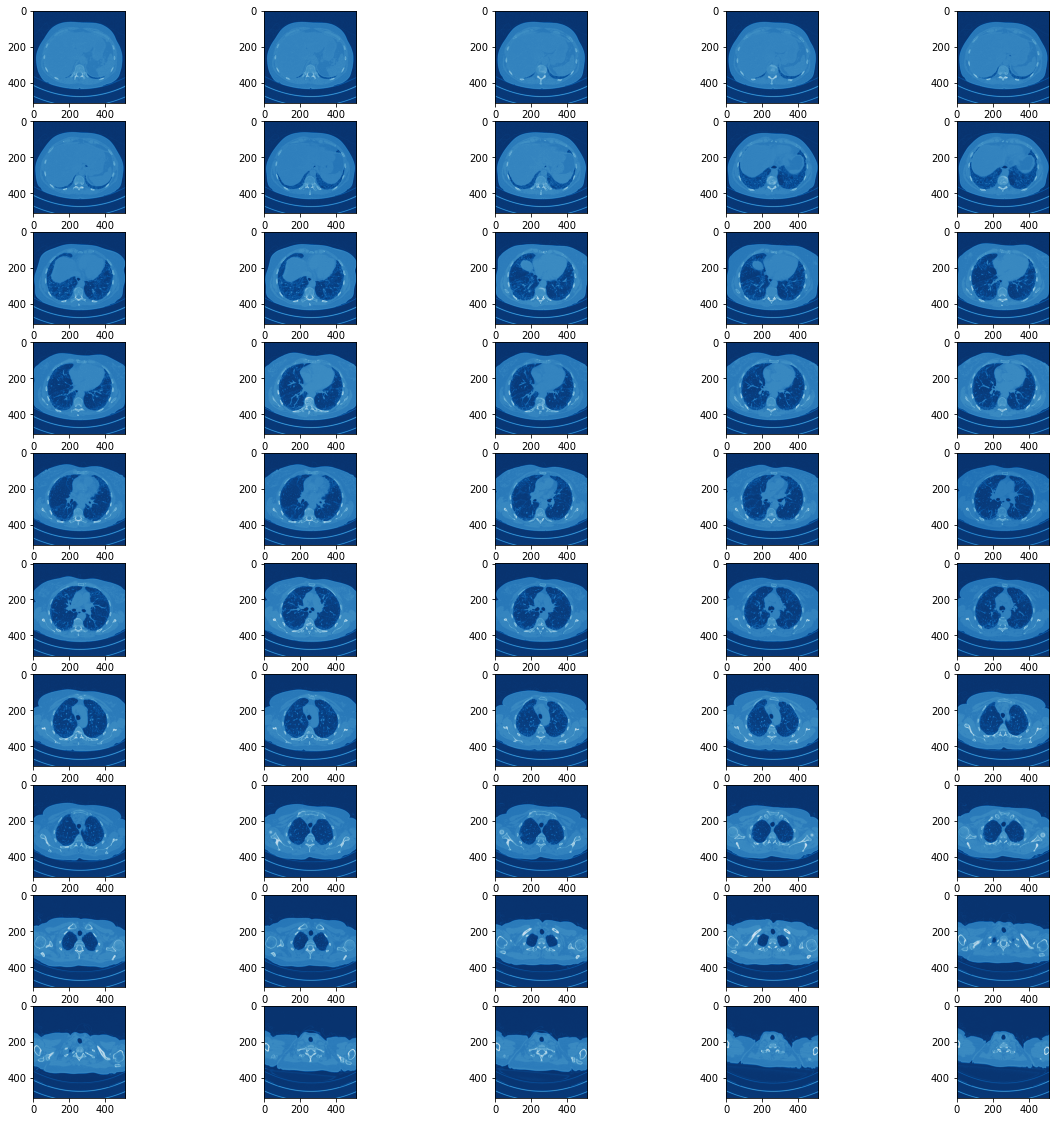

In [65]:
plot_scan(one_sorted_scan, 10, 5, dcm=True)

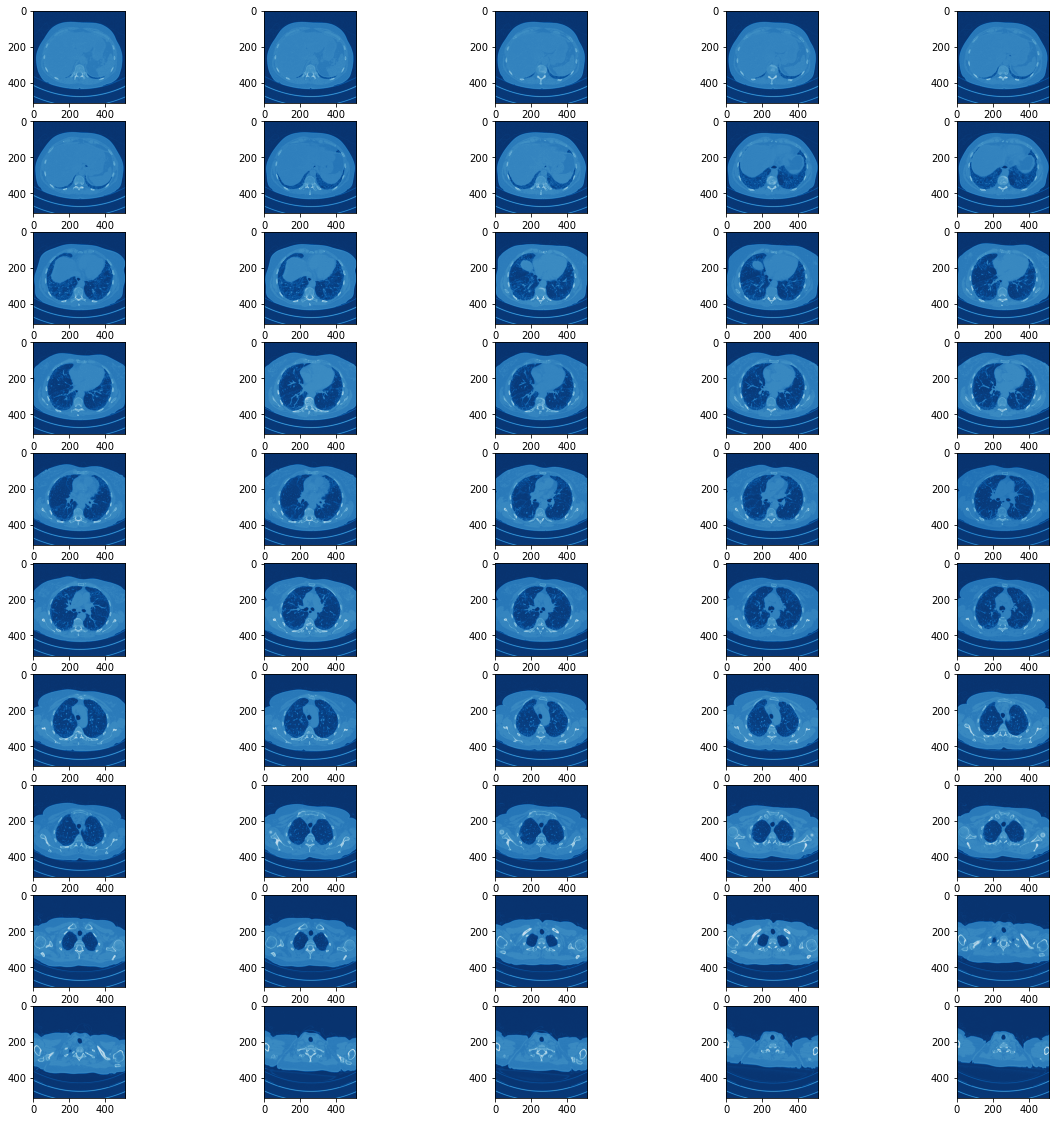

In [66]:
plot_scan(sorted_hu_scan, 10, 5)

In [67]:
#let's pick 4 slices (middle) of interest and go from there
slice_1 = sorted_hu_scan[10]
slice_2 = sorted_hu_scan[15]
slice_3 = sorted_hu_scan[20]
slice_4 = sorted_hu_scan[25]
slices = np.stack([slice_1, slice_2, slice_3, slice_4])
slices.shape

(4, 512, 512)

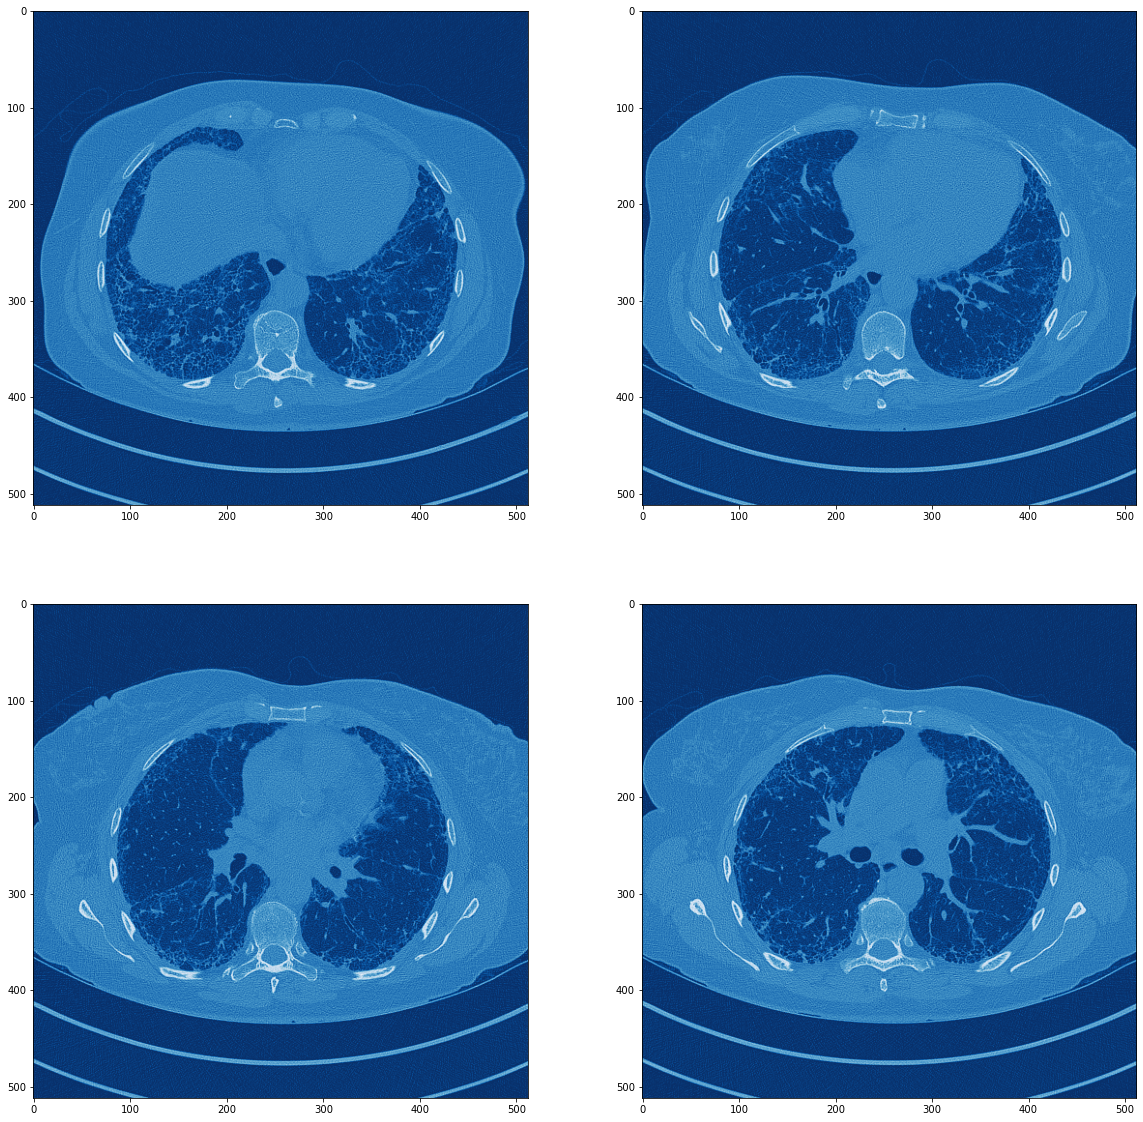

In [68]:
plot_scan(slices, 2, 2)

Ok we have 4 slices from the middle of the scan that are in the hounsfield scale now. 

Let's try out different kernels and see their impact on the slices

In [85]:
blur_kernel = np.ones((5,5))/25
blur_kernel

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]])

In [90]:
blur_slices = cv.filter2D(slices, -1, blur_kernel)

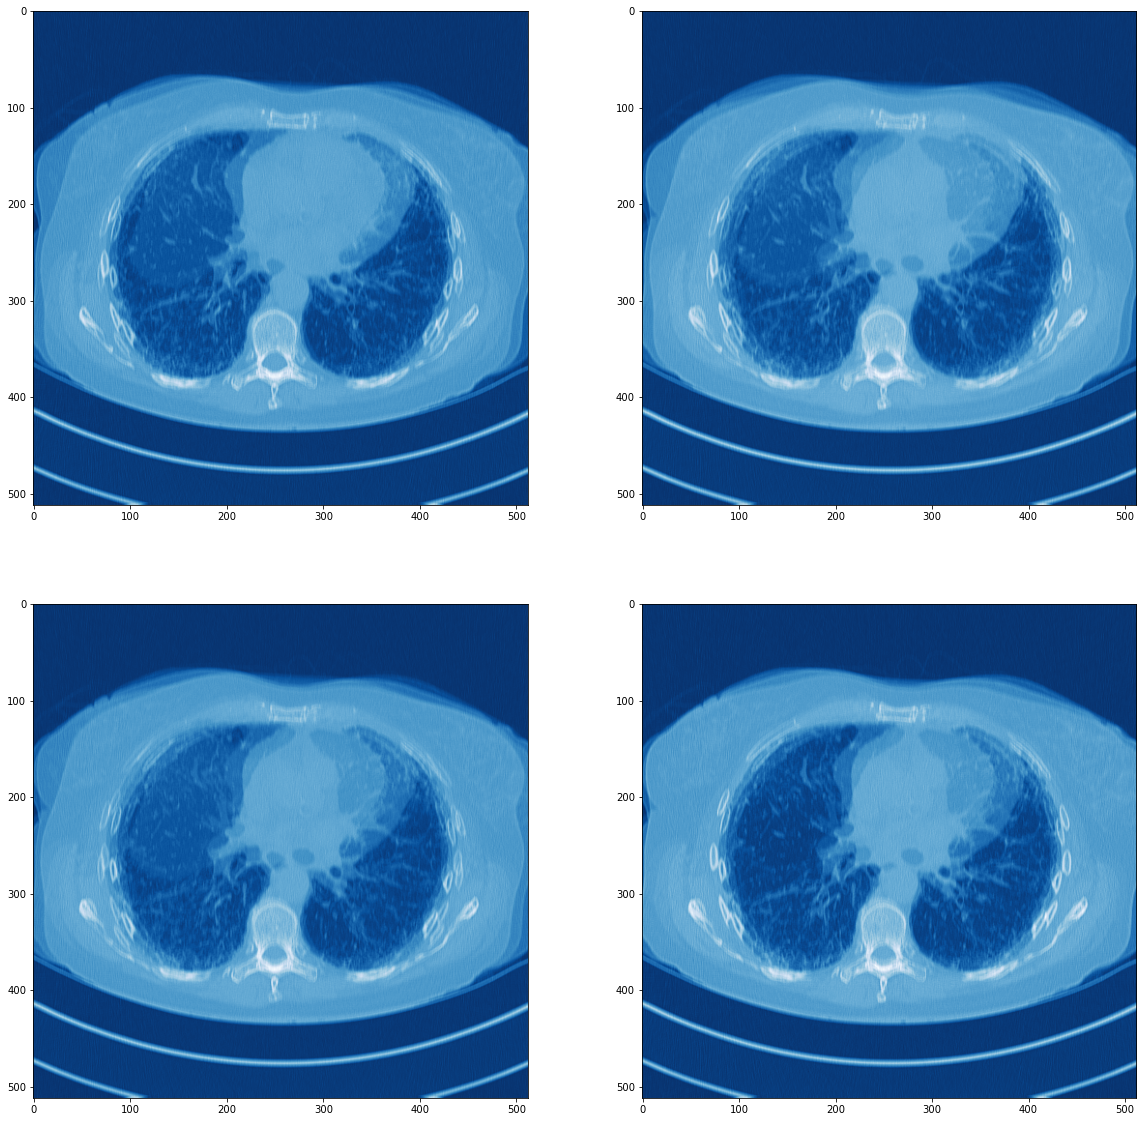

In [91]:
plot_scan(blur_slices, 2, 2)

In [95]:
sharp_kernel = [[0.03, 0.13, 0.03],
               [0.13, 3, 0.13],
               [0.03, 0.13, 0.03]]
sharp_kernel = np.array(sharp_kernel, np.float32)

In [96]:
sharp_slices = cv.filter2D(slices, -1, sharp_kernel)

In [107]:
sharp_comp = np.array([sharp_slices[0:2], slices[0:2]], np.float32)

In [111]:
new = slices.copy()
new[2:4] = sharp_slices[2:4]

In [114]:
sharp_slices[2:4].shape

(2, 512, 512)

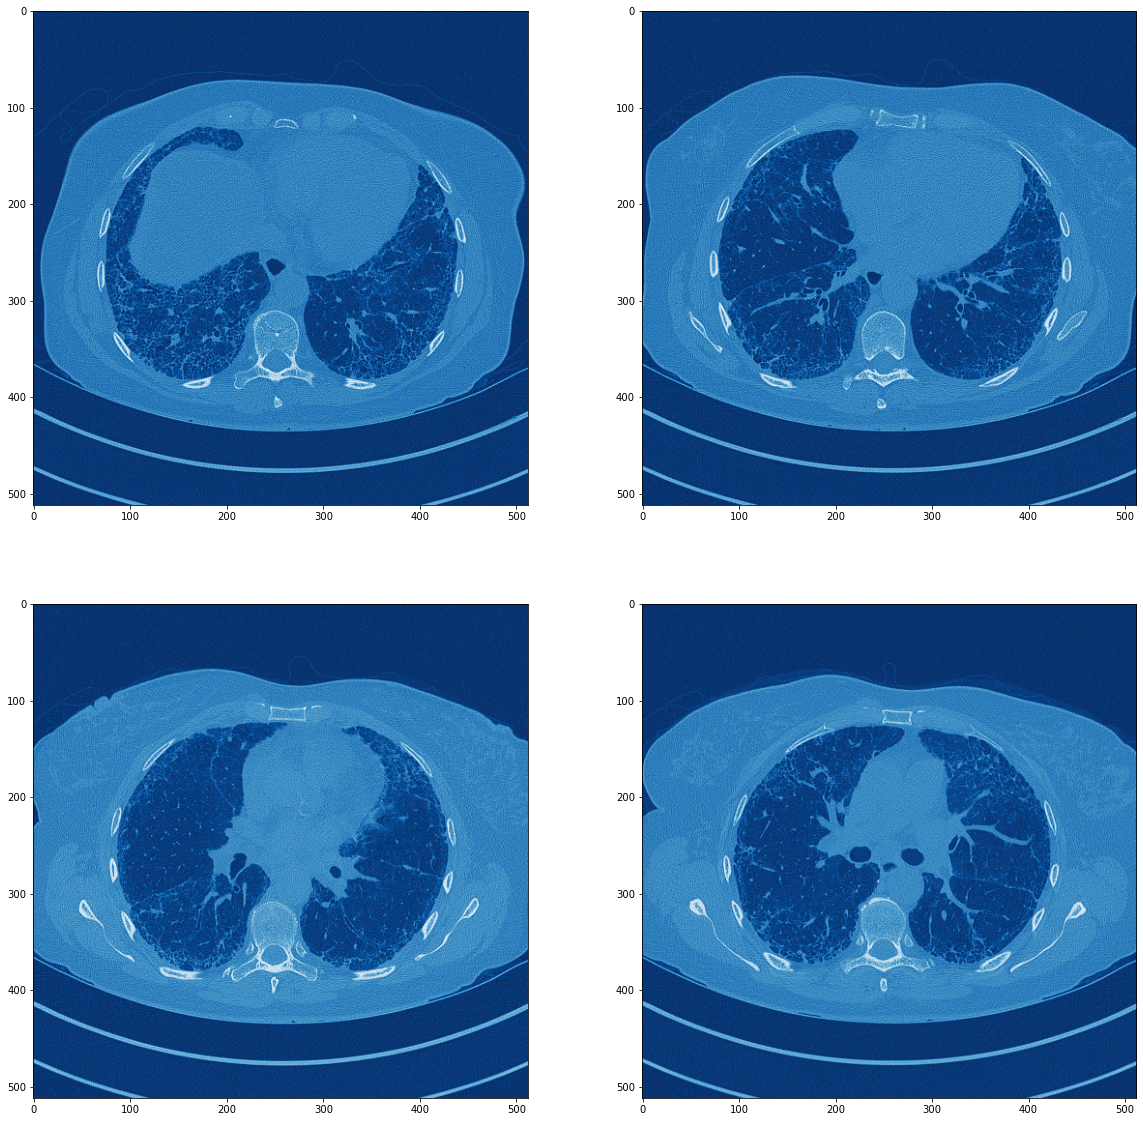

In [112]:
plot_scan(new, 2, 2)